In [84]:
import os

import numpy as np
import pandas as pd
from sqlalchemy import create_engine

import mipipe as mip

# MySQL 데이터베이스 연결 정보
username = 'root'
password = os.getenv('AIMED_PW')
host = '172.28.8.103'
port = '3306'  # 예: '3306'
database = "MIMIC_III"
db_engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# mip configuration
mip.Config.mimic_path = "../mimic3_csv/"

In [30]:
from importlib import reload

reload(mip)  # mymodule을 다시 로드하여 변경 사항 반영.

<module 'mipipe' from '/home/jgpark/PycharmProjects/MIMIC_preprocessing/mipipe/__init__.py'>

In [59]:
# read json file
import json

with open('X.feature_names.json') as f:
    x_feature_names = json.load(f)

d_items = pd.read_csv("../mimic3_csv/D_ITEMS.csv")  # D_ITEMS.csv
d_labitems = pd.read_csv("../mimic3_csv/D_LABITEMS.csv")  # D_LABITEMS.csv
x_feature_names

chartitem_map = {}
labitem_map = {}

for item_id in x_feature_names:
    id = item_id.split("_")[0]
    # if id is number
    if id.isdigit():
        id = int(id)
        try:
            label = d_items[d_items["ITEMID"] == id]
            chartitem_map[id] = label["LABEL"].values[0]
        except:
            try:
                label = d_labitems[d_labitems["ITEMID"] == id]
                labitem_map[id] = label["LABEL"].values[0]
            except:
                print("NOT FOUND: ", id)

In [13]:
import pandas as pd
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor


def process_group(group, x):
    return group["value"].mean()  # 예시로 그룹의 평균값을 계산


def parallel_process_dataframe(df):
    futures = []
    with ProcessPoolExecutor(max_workers=mp.cpu_count()) as executor:
        for _, group in df.groupby('ID'):
            future = executor.submit(process_group, group, 1)
            futures.append(future)

    results = [future.result() for future in futures]
    return results


# 예시 데이터프레임
df = pd.DataFrame({
    'ID': [1, 1, 2, 2, 3, 3],
    'value': [10, 20, 30, 40, 50, 60]
})

result_df = parallel_process_dataframe(df)
print(result_df)

[15.0, 35.0, 55.0]


# Patient_static preprocessing

In [2]:
query = "SELECT * FROM patient_static"
patients_all = pd.read_sql(query, db_engine)
patients_static = mip.PatientStatic()
patients_static.load(patients_all)
patients_static.patients_T_info

,ICUSTAY_ID,T,T_range
0,200001,0,"[2181-11-25 19:06:12, 2181-11-25 19:36:12)"
1,200001,1,"[2181-11-25 19:36:12, 2181-11-25 20:36:12)"
2,200001,2,"[2181-11-25 20:36:12, 2181-11-25 21:36:12)"
3,200001,3,"[2181-11-25 21:36:12, 2181-11-25 22:36:12)"
4,200001,4,"[2181-11-25 22:36:12, 2181-11-25 23:36:12)"
...,...,...,...
2953531,299999,43,"[2117-09-02 04:03:11, 2117-09-02 05:03:11)"
2953532,299999,44,"[2117-09-02 05:03:11, 2117-09-02 06:03:11)"
2953533,299999,45,"[2117-09-02 06:03:11, 2117-09-02 07:03:11)"
2953534,299999,46,"[2117-09-02 07:03:11, 2117-09-02 08:03:11)"


# Chartevents preprocessing

/tmp/ipykernel_807631/563448501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["50%"] = data["50%"].astype(int)


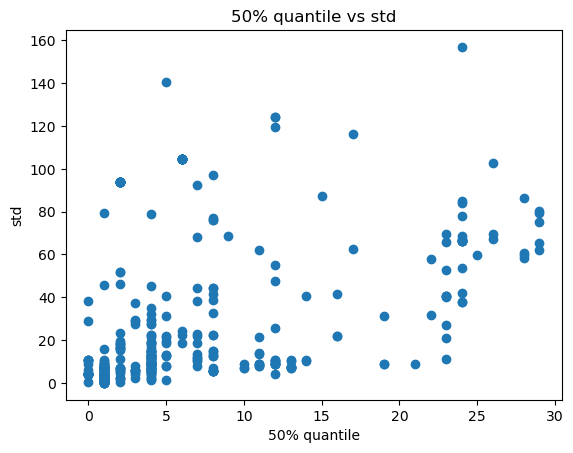

In [16]:
query = "SELECT * FROM CHARTEVENTS LIMIT 10000000"
chartevents_all = pd.read_sql(query, db_engine)

chartevents = mip.Chartevents()
chartevents.load(chartevents_all)

data = chartevents.item_desc_info
data = data[data["50%"] <= 30]

# leave naturla numbers
data["50%"] = data["50%"].astype(int)

# draw scatter plot x = 50%, y = std

import matplotlib.pyplot as plt

plt.scatter(data["50%"], data["std"])
plt.xlabel("50% quantile")
plt.ylabel("std")
plt.title("50% quantile vs std")
plt.show()


In [4]:
query = "SELECT * FROM CHARTEVENTS WHERE ITEMID IN (220045, 224167, 227243, 220050, 220179, 225309, 224639, 226512, 226531, 224690, 220210) ORDER BY CHARTTIME LIMIT 100000;"
icu_patient_original_2 = pd.read_sql(query, db_engine)

In [5]:
chartevents2 = mip.Chartevents()
chartevents2.load(icu_patient_original_2, patients_static.patients_T_info)
chartevents2.process(["mean", "min"])

Chartevents data updated!
-----------------------------------
Filtering...
filter_remove_no_ICUSTAY_ID... Complete!
filter_remove_error... Complete!
filter_remove_labitems... Complete!
Chartevents data updated!
Filtering Complete!
-----------------------------------
Processing...
process_group_variables... Complete!
Chartevents data updated!
process_aggregator... Complete!
process_interval_shift_alignment... Complete!
Processing Complete!


# Inputevents_MV preprocessing

In [112]:
columns = "ROW_ID, ICUSTAY_ID, STARTTIME, ENDTIME, ITEMID, AMOUNT, AMOUNTUOM,RATE, RATEUOM, PATIENTWEIGHT"
columns = "*"
query = f"SELECT {columns} FROM INPUTEVENTS_MV LIMIT 10000000"
inputevents_mv_all = pd.read_sql(query, db_engine)

In [4]:
inputevents_mv = mip.InputeventsMV()
inputevents_mv.load(inputevents_mv_all)

In [113]:
tt = mip.process_rateuom_into_hour_unit(inputevents_mv_all)

process_rateuom_into_hour_unit...	 Complete!	4.88s


In [6]:
tt["ORDERCATEGORYDESCRIPTION"].unique()

array(['Continuous IV', 'Bolus', 'Continuous Med', 'Drug Push',
       'Non Iv Meds'], dtype=object)

In [7]:
tt["RATEUOM"].unique()

array(['mL/hour', None, 'mcg/hour', 'mg/hour', 'units/hour', 'mEq./hour',
       'grams/hour'], dtype=object)

In [8]:
tt[(tt["AMOUNTUOM"] != tt["TOTALAMOUNTUOM"])]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,TOTALAMOUNTUOM,ISOPENBAG,CONTINUEINNEXTDEPT,CANCELREASON,STATUSDESCRIPTION,COMMENTS_EDITEDBY,COMMENTS_CANCELEDBY,COMMENTS_DATE,ORIGINALAMOUNT,ORIGINALRATE
2,3,30354,120396,243526.0,2154-12-24 12:00:00,2154-12-24 14:00:00,221744,0.050000,mg,25.00000,...,ml,0,0,0,FinishedRunning,None,None,NaT,0.05000,25.0
4,5,30354,120396,243526.0,2154-12-24 15:37:00,2154-12-24 17:00:00,221668,5.532400,mg,3.99932,...,ml,0,0,0,Changed,None,None,NaT,98.38330,4.0
8,9,30354,120396,243526.0,2154-12-25 20:00:00,2154-12-25 20:01:00,223260,10.000000,units,NaN,...,None,0,0,0,FinishedRunning,None,None,NaT,10.00000,10.0
10,11,30354,120396,243526.0,2154-12-24 12:41:00,2154-12-28 16:41:00,221744,2.500000,mg,25.00000,...,ml,0,0,2,Rewritten,RN,None,2154-12-24 14:04:00,2.50000,25.0
18,19,30354,120396,243526.0,2154-12-24 12:00:00,2154-12-28 16:00:00,221668,100.000000,mg,1.00000,...,ml,0,0,2,Rewritten,RN,None,2154-12-24 14:10:00,100.00000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618981,3618982,70252,137889,202976.0,2179-10-19 07:08:00,2179-10-19 09:02:00,221668,19.000000,mg,10.00000,...,ml,0,0,0,Changed,None,None,NaT,58.50000,10.0
3618983,3618984,98347,177195,276230.0,2124-10-17 09:32:00,2124-10-17 09:33:00,225942,0.000833,mg,50.00000,...,ml,0,0,0,Paused,None,None,NaT,2.50000,50.0
3618985,3618986,98347,177195,276230.0,2124-10-17 09:33:00,2124-10-17 09:34:00,221668,0.016667,mg,1.00000,...,ml,0,0,0,Paused,None,None,NaT,100.00000,1.0
3618987,3618988,98347,177195,276230.0,2124-10-17 10:35:00,2124-10-17 10:45:00,225942,0.004167,mg,25.00000,...,ml,0,0,0,Paused,None,None,NaT,2.49917,25.0


In [126]:
def map_T_value(row_time, t_info):
    if not isinstance(t_info, pd.DataFrame):
        raise TypeError("t_info should be pandas DataFrame which contains T information of one patient(ICUSTAY_ID)")
    for index, row in t_info.iterrows():
        if row_time in row["T_range"]:
            return row["T"]
    return -1


def process_transform_T_cohort(inputevents: pd.DataFrame, patients_T_info: pd.DataFrame) -> pd.DataFrame:
    result = []
    for index, group in inputevents.groupby("ICUSTAY_ID"):
        T_info = patients_T_info[patients_T_info["ICUSTAY_ID"] == index]
        group_cohort = transform_to_cohort(group, T_info)
        result.append(group_cohort)
    result = [dataframe for dataframe in result if not dataframe.empty]
    if result == []:
        return pd.DataFrame()
    return pd.concat(result)


def transform_to_cohort(inputevents_groupby: pd.DataFrame, T_info: pd.DataFrame) -> pd.DataFrame:
    result = []
    for row in inputevents_groupby.iterrows():
        row = row[1]
        OCD = row["ORDERCATEGORYDESCRIPTION"]
        if OCD in ["Bolus", "Drug Push", "Non Iv Meds"]:
            # one take
            r = one_take_cohort(row, T_info)
        else:
            # continuous
            try:
                r = continuous_cohort(row, T_info)
            except:
                print("ICUSTAY_ID: ", row["ICUSTAY_ID"])
                print("ITEMID: ", row["ITEMID"])
                raise Exception("Error")
        if r is not None:
            result.append(r)

    result = [dataframe for dataframe in result if not dataframe.empty]

    if result == []:
        return pd.DataFrame()
    return pd.concat(result)


def one_take_cohort(row: pd.Series, T_info: pd.DataFrame):
    starttime = row["STARTTIME"]
    T = map_T_value(starttime, T_info)
    row_cohort = pd.DataFrame({
        "T": T,
        "ITEMID": row["ITEMID"],
        "AMOUNT": row["AMOUNT"]
    }, index=[0])
    return row_cohort


def continuous_cohort(row: pd.Series, T_info: pd.DataFrame):
    """

    :param row:
    :param T_info:
    :return:
    """

    starttime = row["STARTTIME"]
    endtime = row["ENDTIME"]

    if starttime > T_info.iloc[-1]["T_range"].right or endtime < T_info.iloc[0]["T_range"].left:
        return None

    starttime = max(starttime, T_info.iloc[0]["T_range"].left)
    endtime = min(endtime, T_info.iloc[-1]["T_range"].right)

    if np.isnan(row["RATE"]):
        rate = calculate_rate_by_hour_unit(row)
    else:
        rate = row["RATE"]

    inputevents_interval = pd.Interval(left=starttime, right=endtime, closed="left")
    start_t = map_T_value(starttime, T_info)
    end_t = map_T_value(endtime, T_info)

    T = []
    administer = []
    for i in range(start_t, end_t + 1):
        T_range = T_info[T_info["T"] == i]["T_range"].values[0]
        overlap = calculate_interval_overlap(inputevents_interval, T_range)
        if overlap > 0:
            T.append(i)
            administer.append(rate * 1 / 60 * overlap)

    row_cohort = pd.DataFrame({
        "T": T,
        "ITEMID": row["ITEMID"],
        "AMOUNT": administer
    }, index=list(range(len(T))))

    return row_cohort


def calculate_rate_by_hour_unit(row: pd.Series):
    starttime = row["STARTTIME"]
    endtime = row["ENDTIME"]
    rate = row["AMOUNT"] / ((endtime - starttime).total_seconds() / 3600)
    return rate


def calculate_interval_overlap(interval1, interval2):
    overlap_start = max(interval1.left, interval2.left)
    overlap_end = min(interval1.right, interval2.right)

    if overlap_start < overlap_end:  # if overlap exists
        overlap_length = overlap_end - overlap_start
        return overlap_length.total_seconds() / 60  # return minutes
    else:
        return 0


aaa = process_transform_T_cohort(aa[aa["AMOUNT"] > 0], patients_static.patients_T_info)
aaa

,T,ITEMID,AMOUNT
0,-1,225798,1.0
0,-1,220949,200.0
0,17,225798,1.0
0,17,220949,200.0
0,-1,225799,180.0
...,...,...,...
0,-1,220949,200.0
0,-1,225799,30.0
0,40,221468,30.0
0,-1,225879,750.0


In [125]:
aa = tt[tt["ICUSTAY_ID"].isin([200647])]

In [127]:
tt[tt["ICUSTAY_ID"] == 200647]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,TOTALAMOUNTUOM,ISOPENBAG,CONTINUEINNEXTDEPT,CANCELREASON,STATUSDESCRIPTION,COMMENTS_EDITEDBY,COMMENTS_CANCELEDBY,COMMENTS_DATE,ORIGINALAMOUNT,ORIGINALRATE
61163,61164,27576,199655,200647.0,2116-07-04 09:00:00,2116-07-04 09:01:00,225798,1.0,dose,NaN,...,ml,0,0,0,FinishedRunning,None,None,NaT,1.0,1.000000
61164,61165,27576,199655,200647.0,2116-07-04 09:00:00,2116-07-04 09:01:00,220949,200.0,ml,NaN,...,ml,0,0,0,FinishedRunning,None,None,NaT,200.0,0.000000
61165,61166,27576,199655,200647.0,2116-07-02 07:59:00,2116-07-02 08:00:00,225798,1.0,dose,NaN,...,ml,0,0,0,FinishedRunning,None,None,NaT,1.0,1.000000
61166,61167,27576,199655,200647.0,2116-07-02 07:59:00,2116-07-02 08:00:00,220949,200.0,ml,NaN,...,ml,0,0,0,FinishedRunning,None,None,NaT,200.0,0.000000
61167,61168,27576,199655,200647.0,2116-07-04 08:24:00,2116-07-04 08:25:00,225799,180.0,ml,NaN,...,ml,0,0,0,FinishedRunning,None,None,NaT,180.0,180.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61262,61263,27576,199655,200647.0,2116-07-05 10:13:00,2116-07-05 11:13:00,221456,2.0,grams,NaN,...,ml,0,0,0,FinishedRunning,None,None,NaT,2.0,0.033333
61263,61264,27576,199655,200647.0,2116-07-04 20:00:00,2116-07-04 20:01:00,225799,30.0,ml,NaN,...,ml,0,0,0,FinishedRunning,None,None,NaT,30.0,30.000000
61264,61265,27576,199655,200647.0,2116-07-03 06:41:00,2116-07-03 06:42:00,221468,30.0,mg,NaN,...,None,0,0,0,FinishedRunning,None,None,NaT,30.0,30.000000
61265,61266,27576,199655,200647.0,2116-07-03 19:24:00,2116-07-03 19:25:00,225879,750.0,mg,NaN,...,ml,0,0,0,FinishedRunning,None,None,NaT,750.0,750.000000


In [128]:
patients_static.patients_T_info[patients_static.patients_T_info["ICUSTAY_ID"] == 200647]

,ICUSTAY_ID,T,T_range
19488,200647,0,"[2116-07-01 14:36:44, 2116-07-01 15:06:44)"
19489,200647,1,"[2116-07-01 15:06:44, 2116-07-01 16:06:44)"
19490,200647,2,"[2116-07-01 16:06:44, 2116-07-01 17:06:44)"
19491,200647,3,"[2116-07-01 17:06:44, 2116-07-01 18:06:44)"
19492,200647,4,"[2116-07-01 18:06:44, 2116-07-01 19:06:44)"
19493,200647,5,"[2116-07-01 19:06:44, 2116-07-01 20:06:44)"
19494,200647,6,"[2116-07-01 20:06:44, 2116-07-01 21:06:44)"
19495,200647,7,"[2116-07-01 21:06:44, 2116-07-01 22:06:44)"
19496,200647,8,"[2116-07-01 22:06:44, 2116-07-01 23:06:44)"
19497,200647,9,"[2116-07-01 23:06:44, 2116-07-02 00:06:44)"


In [130]:
3815.57784*58/60

3688.391912